# 导入必要的库

我们需要导入一个叫 [captcha](https://github.com/lepture/captcha/) 的库来生成验证码。

我们生成验证码的字符由数字和大写字母组成。

```sh
pip install captcha numpy matplotlib tensorflow-gpu pydot tqdm

```
采用RNN + CTC作为损失函数，避免标签对齐，且可用于不定长。注意：

在CPU环境，训练时要注释掉：workers=4, use_multiprocessing=True,同时采用GRU()
采用Google Colab上训练好的模型ctc_best.h5，成功率约95%

Q：如何实现可变长度？


In [6]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
characters = string.digits + string.ascii_uppercase
print(characters)

modelname = '../DATA/model/T_Captcha_break/ctc_best.h5'

width, height, n_len, n_class = 128, 64, 4, len(characters) + 1

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


# 防止 tensorflow 占用所有显存

In [2]:
import tensorflow as tf
import tensorflow.keras.backend as K

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

# 定义 CTC Loss

In [7]:
import tensorflow.keras.backend as K

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

# 定义网络结构

In [8]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

input_tensor = Input((height, width, 3))
x = input_tensor
for i, n_cnn in enumerate([2, 2, 2, 2, 2]):
    for j in range(n_cnn):
        x = Conv2D(32*2**min(i, 3), kernel_size=3, padding='same', kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
    x = MaxPooling2D(2 if i < 3 else (2, 1))(x)

# ？
x = Permute((2, 1, 3))(x)
x = TimeDistributed(Flatten())(x)

rnn_size = 128

# 使用GPU：
# x = Bidirectional(CuDNNGRU(rnn_size, return_sequences=True))(x)
# x = Bidirectional(CuDNNGRU(rnn_size, return_sequences=True))(x)

# 使用CPU：
x = Bidirectional(GRU(rnn_size, return_sequences=True))(x)
x = Bidirectional(GRU(rnn_size, return_sequences=True))(x)

x = Dense(n_class, activation='softmax')(x)

base_model = Model(inputs=input_tensor, outputs=x)

In [9]:
labels = Input(name='the_labels', shape=[n_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

# 如何实现可变长度？
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([x, labels, input_length, label_length])

model = Model(inputs=[input_tensor, labels, input_length, label_length], outputs=loss_out)

# 网络结构可视化

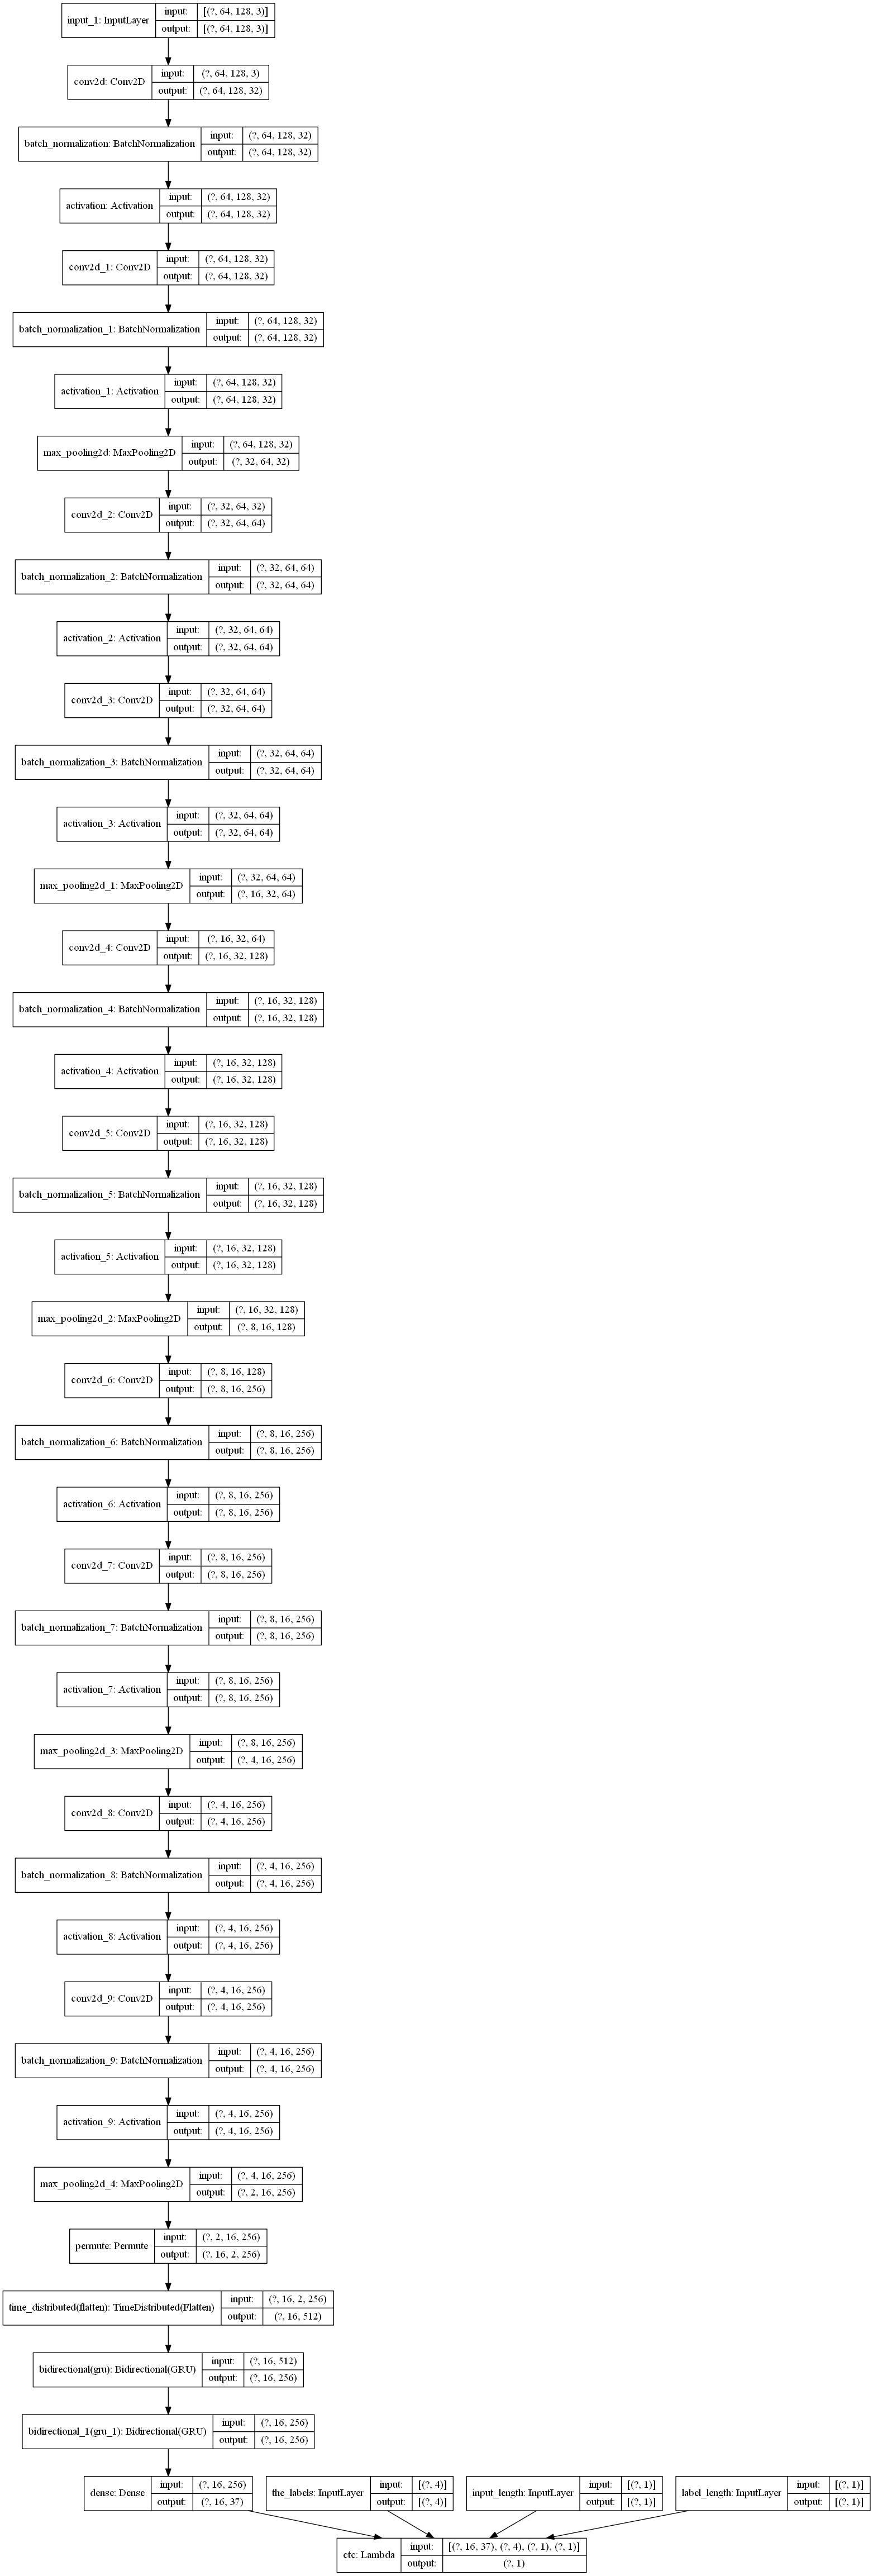

In [6]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(model, to_file='ctc.png', show_shapes=True)
Image('ctc.png')

In [7]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 128, 3)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 128, 32)       896       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 64, 128, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 64, 128, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 128, 32)       9248      
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 64, 128, 32)       128       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 128, 32)       0         
__________

# 定义数据生成器

In [10]:
from tensorflow.keras.utils import Sequence

class CaptchaSequence(Sequence):
    def __init__(self, characters, batch_size, steps, n_len=4, width=128, height=64, 
                 input_length=16, label_length=4):
        self.characters = characters
        self.batch_size = batch_size
        self.steps = steps
        self.n_len = n_len
        self.width = width
        self.height = height
        self.input_length = input_length
        self.label_length = label_length
        self.n_class = len(characters)
        self.generator = ImageCaptcha(width=width, height=height)
    
    def __len__(self):
        return self.steps

    def __getitem__(self, idx):
        X = np.zeros((self.batch_size, self.height, self.width, 3), dtype=np.float32)
        y = np.zeros((self.batch_size, self.n_len), dtype=np.uint8)
        input_length = np.ones(self.batch_size)*self.input_length
        label_length = np.ones(self.batch_size)*self.label_length
        for i in range(self.batch_size):
            random_str = ''.join([random.choice(self.characters) for j in range(self.n_len)])
            X[i] = np.array(self.generator.generate_image(random_str)) / 255.0
            y[i] = [self.characters.find(x) for x in random_str]
        return [X, y, input_length, label_length], np.ones(self.batch_size)

train_data = CaptchaSequence(characters, batch_size=64, steps=1000)
valid_data = CaptchaSequence(characters, batch_size=64, steps=50)


# 测试生成器

Tensor("input_length:0", shape=(None, 1), dtype=int64) Tensor("label_length:0", shape=(None, 1), dtype=int64)


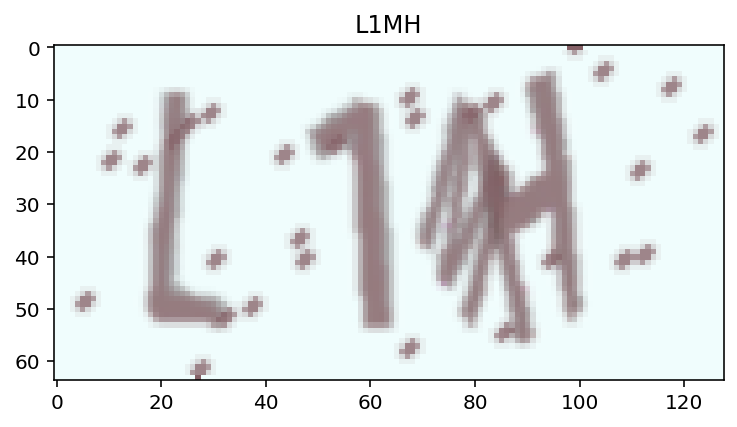

In [11]:
data = CaptchaSequence(characters, batch_size=1, steps=1)
[X_test, y_test, _, _], _  = data[0]
plt.imshow(X_test[0])
plt.title(''.join([characters[x] for x in y_test[0]]))
print(input_length, label_length)

# 准确率回调函数

In [12]:
from tqdm import tqdm

def evaluate(model, batch_size=128, steps=20):
    batch_acc = 0
    valid_data = CaptchaSequence(characters, batch_size, steps)
    for [X_test, y_test, _, _], _ in valid_data:
        y_pred = base_model.predict(X_test)
        shape = y_pred.shape
        out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(shape[0])*shape[1])[0][0])[:, :4]
        if out.shape[1] == 4:
            batch_acc += (y_test == out).all(axis=1).mean()
    return batch_acc / steps

In [13]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from tensorflow.keras.optimizers import *

class Evaluate(Callback):
    def __init__(self):
        self.accs = []
    
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        acc = evaluate(base_model)
        logs['val_acc'] = acc
        self.accs.append(acc)
        print(f'\nacc: {acc*100:.4f}')

# 训练模型

In [ ]:
callbacks = [EarlyStopping(patience=5), Evaluate(), 
             CSVLogger('ctc.csv'), ModelCheckpoint(modelname, save_best_only=True)]

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(1e-3, amsgrad=True))
model.fit_generator(train_data, epochs=100, validation_data=valid_data, 
#                     workers=4, use_multiprocessing=True,
                    callbacks=callbacks)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1000 steps, validate for 100 steps
Epoch 1/100


Exception in thread Thread-7:
Traceback (most recent call last):
  File "C:\Anaconda3\envs\TF21-PY37\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Anaconda3\envs\TF21-PY37\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Anaconda3\envs\TF21-PY37\lib\site-packages\tensorflow_core\python\keras\utils\data_utils.py", line 844, in _run
    with closing(self.executor_fn(_SHARED_SEQUENCES)) as executor:
  File "C:\Anaconda3\envs\TF21-PY37\lib\site-packages\tensorflow_core\python\keras\utils\data_utils.py", line 823, in pool_fn
    initargs=(seqs, None, get_worker_id_queue()))
  File "C:\Anaconda3\envs\TF21-PY37\lib\multiprocessing\context.py", line 119, in Pool
    context=self.get_context())
  File "C:\Anaconda3\envs\TF21-PY37\lib\multiprocessing\pool.py", line 176, in __init__
    self._repopulate_pool()
  File "C:\Anaconda3\envs\TF21-PY37\lib\multiprocessing\pool.py", line 241, in _repopulate_pool
    w.start()
  File

### 载入最好的模型继续训练一会

In [15]:
model.load_weights(modelname)

callbacks = [EarlyStopping(patience=5), Evaluate(), 
             CSVLogger('ctc.csv', append=True), ModelCheckpoint(modelname, save_best_only=True)]

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(1e-4, amsgrad=True))
model.fit_generator(train_data, epochs=10, validation_data=valid_data, verbose=1, 
#                     workers=4, use_multiprocessing=True,
                    callbacks=callbacks)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1000 steps, validate for 100 steps
Epoch 1/10
   7/1000 [..............................] - ETA: 2:04:09 - loss: 0.1138WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss


KeyboardInterrupt: 

In [14]:
model.load_weights(modelname)

# 测试模型

[(3, '3'),
 (10, 'A'),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (34, 'Y'),
 (14, 'E')]

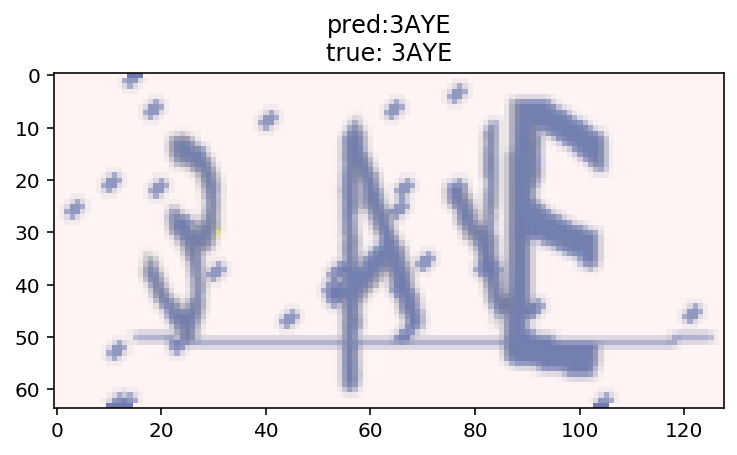

In [21]:
characters2 = characters + ' '

data = CaptchaSequence(characters, n_len=4, batch_size=1, steps=1)

[X_test, y_test, _, _], _  = data[0]
y_pred = base_model.predict(X_test)
out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0])*y_pred.shape[1], )[0][0])[:, :4]
out = ''.join([characters[x] for x in out[0]])
y_true = ''.join([characters[x] for x in y_test[0]])

plt.imshow(X_test[0])
plt.title('pred:' + str(out) + '\ntrue: ' + str(y_true))

argmax = np.argmax(y_pred, axis=2)[0]
list(zip(argmax, ''.join([characters2[x] for x in argmax])))

# 计算模型总体准确率

In [22]:
evaluate(base_model)

0.947265625

# 保存模型

In [17]:
base_model.save('ctc.h5', include_optimizer=False)

# 可视化训练曲线

```sh
pip install pandas
```

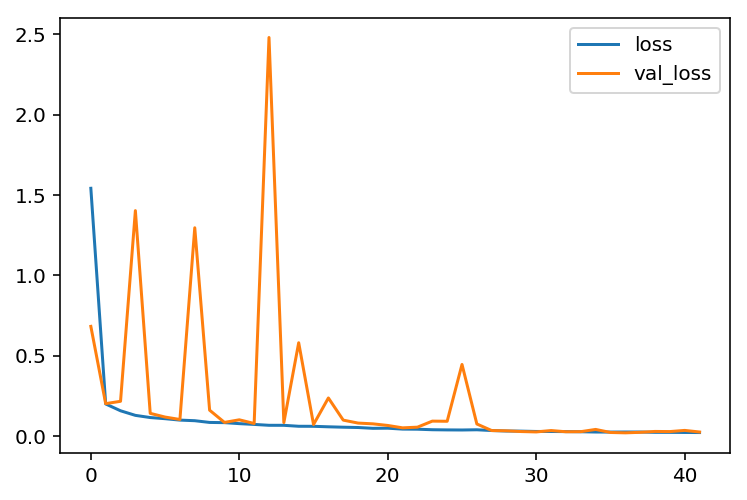

In [21]:
import pandas as pd

df = pd.read_csv('ctc.csv')
df[['loss', 'val_loss']].plot()

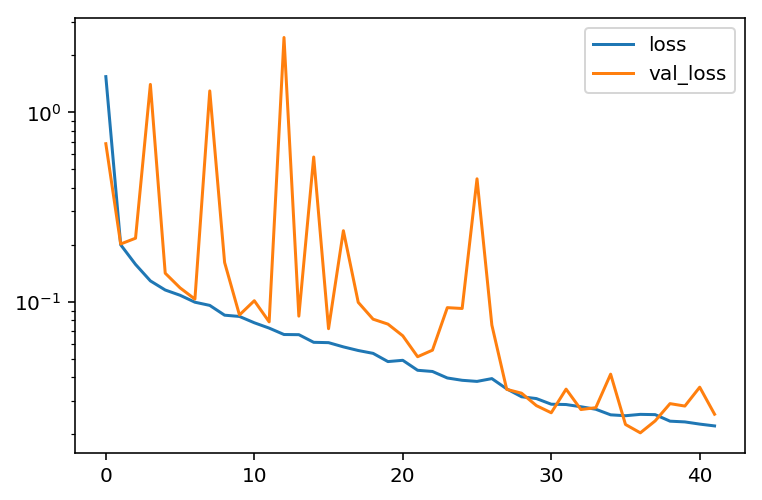

In [22]:
df[['loss', 'val_loss']].plot(logy=True)

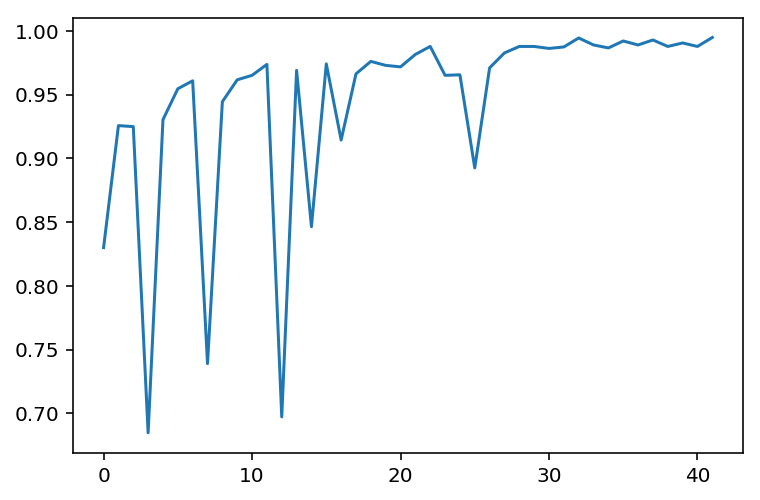

In [23]:
df['val_acc'].plot()